# Mini-Project: SVM & LR Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<a id="top"></a>
## Contents
* <a href="#Create">Create Models</a>
    * <a href="#Prep">Data Preparation</a>
    * <a href="#LR">Logistic Regression Model</a>
    * <a href="#SVM">Support Vector Machine Model</a>
* <a href="#Model">Model Advantages</a>
* <a href="#Interpret">Interpret Feature Importance</a>
* <a href="#Support">Interpret Support Vectors</a>

In [63]:
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics as mt

### Supporting Functions

In [3]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [4]:
# Brett's directory
# Desktop
# %cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory. Either uncomment the cd statement above or make your own cd.
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directorY 
#%cd "C:\Users\Nicole Wittlin\Documents\7331DataMining\EducationDataNC\2017\Raw Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets


<a id="Create"></a><a href="#top">Back to Top</a> 
## Create Models (50 points)
<a id="Prep"></a>
### Data Preparation

There are 403 columns in our dataset. We dropped any columns that have zero variance and only dropped one column. We also wanted to remove highly correlated variables to reduce multi-collinearity. For a Pearson R threshold of 0.8, we removed any variables where the `r` value was greater than `0.8`. As a result, we dropped 124 highly correlated variables in the code blocks below. We used the dropped columns dataset to build our logistic regression model and for our initial SVM model to compare the performance between the two models. We will talk about the model performance later on in our notebook.

In [5]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [6]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [7]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print("Columns dropped: {}".format(len(to_drop)))

Columns dropped: 124


We performed some data preparation before running our logistic regression and SVM models. Since our target variable is a continuous variable, we needed to split the target variable evenly into a binary response so our data was split at the median. We created a new variable called `schoolPctTarget` and assigned a value of `1` to schools with students enrolled in a postsecondary institution greater or equal to the median value (52.18%) and `0` to schools with less than the median value of 52.18%.

It is important to create a split dataset so we do not train a model that is better at classifying one side than the other therefore, we want our model to be trained on both binary values. 

In [8]:
# Split the target variable based on the median value
medianSplit = dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()

dfDropped['schoolPctTarget'] = np.where(dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= medianSplit, 1, 0)

print("Median: {}".format(medianSplit))
print("{} of {}: {}%".format(dfDropped['schoolPctTarget'].sum(), dfDropped.shape[0], 
                             round(dfDropped['schoolPctTarget'].sum()/dfDropped.shape[0] * 100,2)))

Median: 52.178614549748545
235 of 470: 50.0%


### Column preparation

At this point, the dataset contains 'future' information that the model should not be aware of. We need to drop these columns before we build the model. In addition, some of the column names don't start with alpha characters which cause code later in the notebook to miss these columns and not graph the most significant support vectors correctly

In [9]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfDropped.filter(regex = r'sch_pct')

dfDropped.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfDropped.columns = dfDropped.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfDropped.columns = dfDropped.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfDropped.rename(columns=renameCols, inplace = True)

In [10]:
y = dfDropped['schoolPctTarget']

In [11]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 42)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None)


In [12]:
maxCols = dfDropped.shape[1]
X = dfDropped.iloc[:,0:maxCols-2]

### Data split
Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [13]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2, random_state = 42)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

Store these variables for us later in the SVM model

In [14]:
xTrainLR = xTrain
xTestLR = xTest
yTrainLR = yTrain
yTestLR = yTest

<a id = "LR"></a>
## Logistic Regression

In [15]:
#First model will use Lasso (Least Absolute Shrinkage and Selection Operator) regression which adds a penalty term to the coefficients to shrink the less important ones to zero. Thereby helping with further feature selection. Through trial and error the first cost penalty (C) we will use a cost of 1.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[26 14]
 [17 37]]
Accuracy (1-Fold) 0.6702127659574468
Accuracy (10-Fold): 0.67 (+/- 0.08)


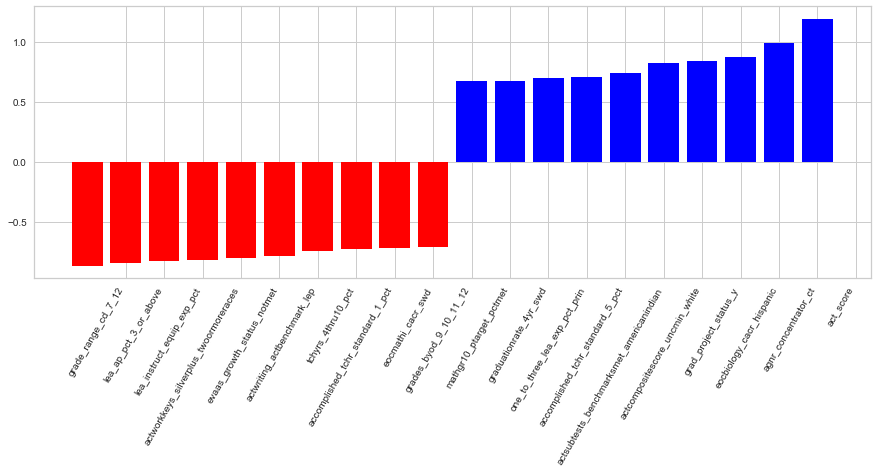

In [16]:
# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [17]:
#The second model uses Lasso regression but changes the cost to 0.05.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=0.05, class_weight=None, random_state=2) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[27 13]
 [11 43]]
Accuracy (1-Fold) 0.7446808510638298
Accuracy (10-Fold): 0.70 (+/- 0.09)


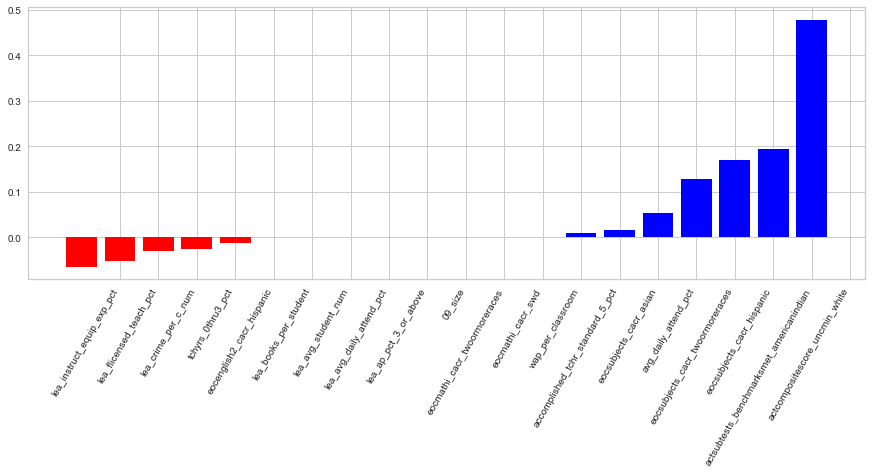

In [18]:
plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [19]:
#Our third model will use Ridge regression which also adds a different penalty term. Through trial and error the first cost penalty (C) we will use a cost of 1.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 42))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[27 13]
 [20 34]]
Accuracy (1-Fold) 0.648936170212766
Accuracy (10-Fold): 0.68 (+/- 1.47)


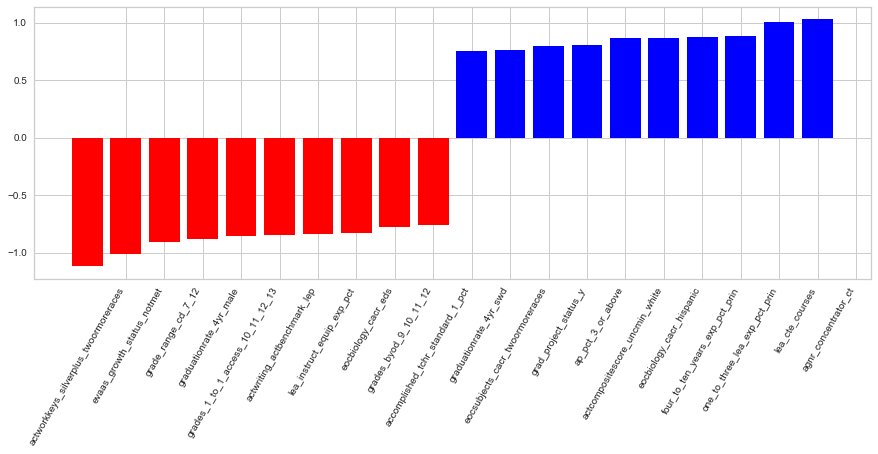

In [20]:
plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [21]:
#The fourth model uses Ridge regression but changes the cost to 0.05.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[29 11]
 [14 40]]
Accuracy (1-Fold) 0.7340425531914894
Accuracy (10-Fold): 0.68 (+/- 0.09)


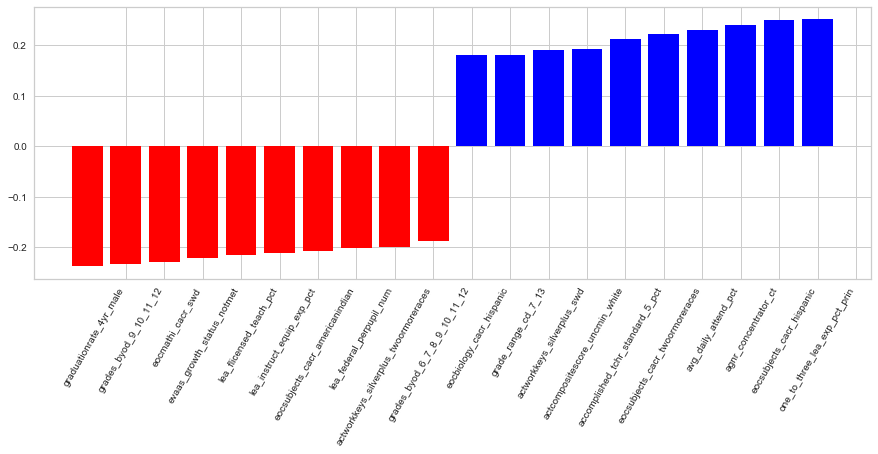

In [22]:
# Graph the columns in terms of prediction weight
#cv = CountVectorizer()
#cv.fit(XCopy)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features = 10)

<a id="SVM"></a>
## Support Vector Machines

### Linear Regression Features
For comparison against the two models, build a model with the attributes used for the linear regression model

In [23]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

Train the model and determine the best parameter to use for our model

In [24]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrainLR, yTrainLR)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 00:51:32.693125
Wall time: 2.48 s
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.699 (+/-0.108) for {'C': 1}
0.697 (+/-0.095) for {'C': 10}
0.697 (+/-0.100) for {'C': 100}
0.697 (+/-0.100) for {'C': 1000}



Using the best parameter, we build our model and then test it against the data

In [25]:
# Set model to best values found
cls = SVC(C = bestValues['C'], kernel = 'linear')

# Train
cls.fit(xTrainLR, yTrainLR)

# Predict test values
yhat = cls.predict(xTestLR)

# Show model performance
print("Accuracy Value:\n {}".format(accuracy_score(yTest,y_hat)))
print("Confusion Matrix:\n {}".format(confusion_matrix(yTest, yhat)))
print("Classification Report:\n {}".format(classification_report(yTest, yhat)))

Accuracy Value:
 0.7340425531914894
Confusion Matrix:
 [[26 14]
 [23 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.65      0.58        40
           1       0.69      0.57      0.63        54

   micro avg       0.61      0.61      0.61        94
   macro avg       0.61      0.61      0.61        94
weighted avg       0.62      0.61      0.61        94



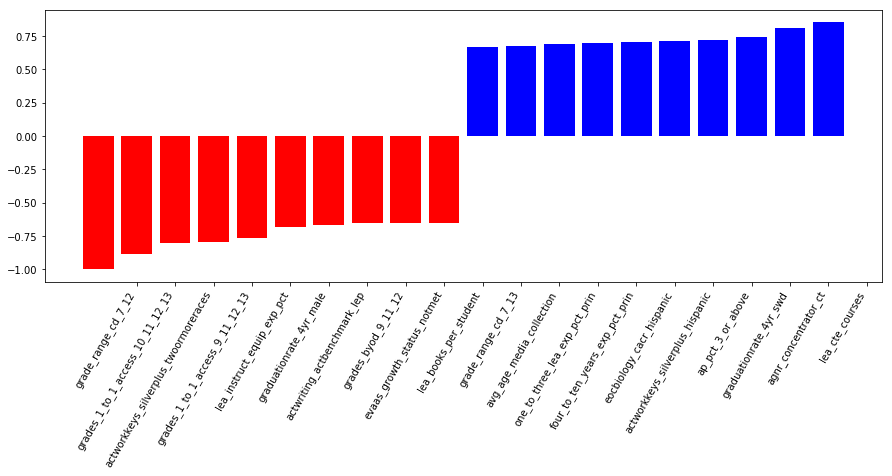

In [26]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

### ANOVA Feature Selection
Using the ANOVA F-value to determine which columns have the greatest proportion of variance, we select the top 10% to be used in our model. The F-value tells us which column(s) help to explain the greatest amount of variance in the target variable. The columns with the highest proportion allows the model to solve for the greatest separation on attributes for classification.

In [71]:
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct')

dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Subset the data to exclude the target variable
maxCols = dfPublicHS.shape[1]
X = dfPublicHS.iloc[:,0:maxCols-2]

In [66]:
# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

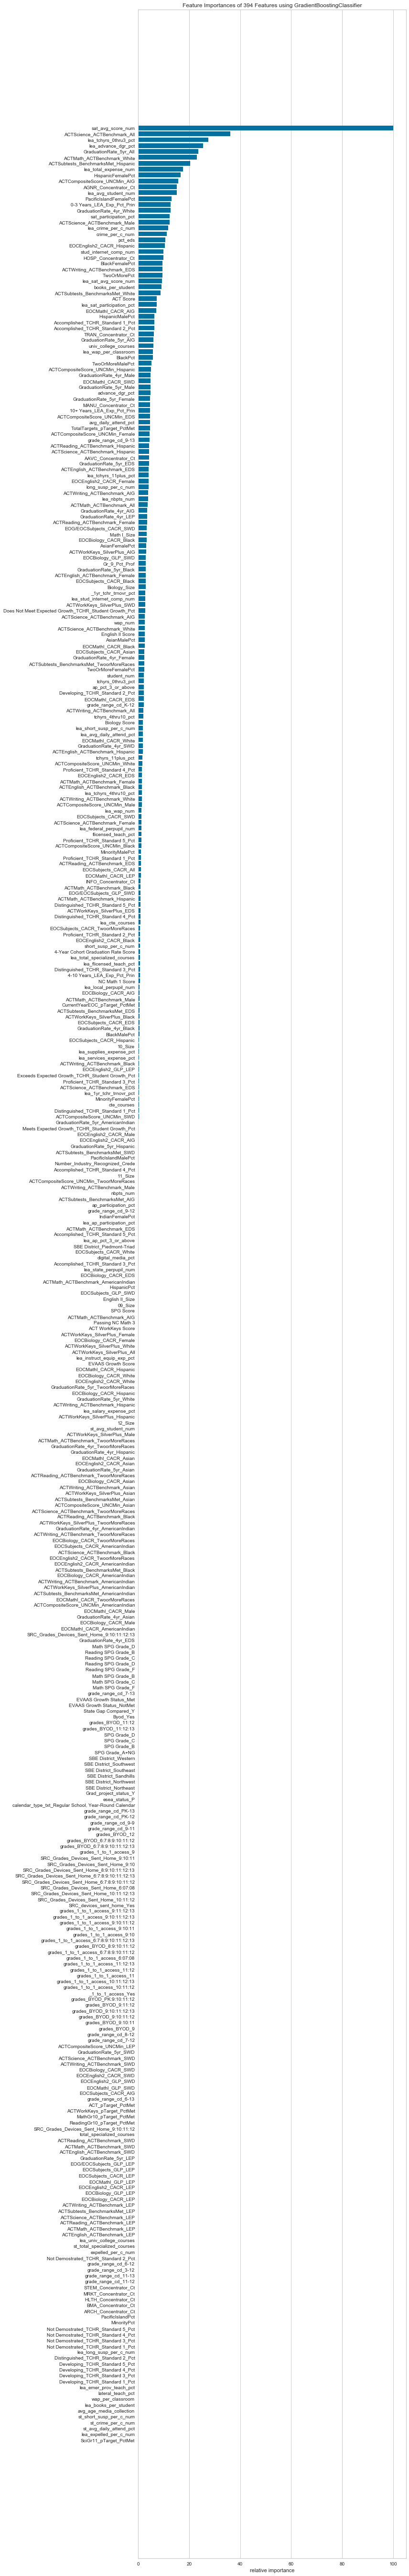

In [76]:
fig = plt.figure(figsize=(12,75))
ax = fig.add_subplot()

viz = yb.features.importances.FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(X, y)
viz.poof()

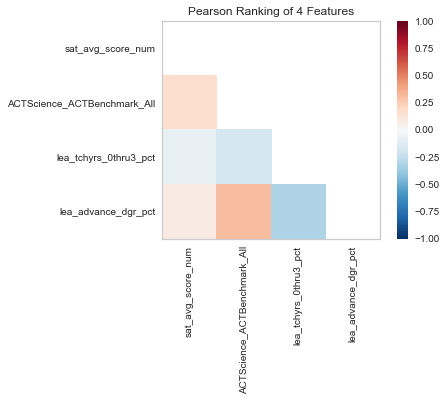

array([[1.108e+03, 2.630e+01, 2.110e-01, 2.270e-01],
       [1.088e+03, 2.180e+01, 2.110e-01, 2.270e-01],
       [9.240e+02, 8.100e+00, 2.110e-01, 2.270e-01],
       ...,
       [9.960e+02, 1.230e+01, 1.950e-01, 1.890e-01],
       [0.000e+00, 2.550e+01, 1.950e-01, 1.890e-01],
       [1.137e+03, 2.070e+01, 1.030e-01, 1.720e-01]])

In [81]:
features = ['sat_avg_score_num', 'ACTScience_ACTBenchmark_All', 'lea_tchyrs_0thru3_pct', 'lea_advance_dgr_pct']

vis = yb.features.Rank2D(features=features, algorithm='pearson')
vis.fit_transform_poof(tempX,tempY)

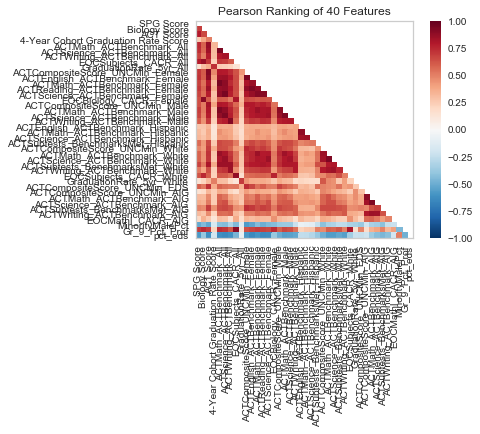

In [68]:
vis = yb.features.Rank2D(algorithm="pearson")
vis.fit_transform(X)
vis.poof()

Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [33]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2, random_state = 42)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

Here we create a range of values to test the model against to determine which parameters provide the best result.

In [34]:
xTrain.shape

(376, 40)

In [39]:
1/40

0.025

In [53]:
# Set parameter turning values and create a grid of models to run
gamma_opts = np.logspace(-6, 0, num = 20)
param_grid = dict(gamma=gamma_opts, C=[1,10,100,1000])
cv = StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=42)
gridRBF = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

Run the models and show results

In [54]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
gridRBF.fit(xTrain, yTrain)

Training started at: 20:49:30.191092


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': array([1.00000e-06, 2.06914e-06, 4.28133e-06, 8.85867e-06, 1.83298e-05,
       3.79269e-05, 7.84760e-05, 1.62378e-04, 3.35982e-04, 6.95193e-04,
       1.43845e-03, 2.97635e-03, 6.15848e-03, 1.27427e-02, 2.63665e-02,
       5.45559e-02, 1.12884e-01, 2.33572e-01, 4.83293e-01, 1.00000e+00]), 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
bestValues = gridRBF.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridRBF scores on development set:")
print()
means = gridRBF.cv_results_['mean_test_score']
stds = gridRBF.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridRBF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Best parameters set found on development set:

{'C': 10, 'gamma': 0.002976351441631316}

gridRBF scores on development set:

0.513 (+/-0.000) for {'C': 1, 'gamma': 1e-06}
0.513 (+/-0.000) for {'C': 1, 'gamma': 2.06913808111479e-06}
0.513 (+/-0.000) for {'C': 1, 'gamma': 4.281332398719396e-06}
0.513 (+/-0.000) for {'C': 1, 'gamma': 8.858667904100832e-06}
0.513 (+/-0.000) for {'C': 1, 'gamma': 1.8329807108324375e-05}
0.513 (+/-0.000) for {'C': 1, 'gamma': 3.792690190732254e-05}
0.568 (+/-0.050) for {'C': 1, 'gamma': 7.847599703514606e-05}
0.691 (+/-0.076) for {'C': 1, 'gamma': 0.0001623776739188721}
0.695 (+/-0.068) for {'C': 1, 'gamma': 0.0003359818286283781}
0.712 (+/-0.069) for {'C': 1, 'gamma': 0.0006951927961775605}
0.713 (+/-0.070) for {'C': 1, 'gamma': 0.0014384498882876629}
0.725 (+/-0.080) for {'C': 1, 'gamma': 0.002976351441631316}
0.728 (+/-0.066) for {'C': 1, 'gamma': 0.00615848211066026}
0.716 (+/-0.084) for {'C': 1, 'gamma': 0.012742749857031322}
0.712 (+/-0.078) for {'C': 

Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [56]:
# Set model to best values found
cls = SVC(C = bestValues['C'], gamma = bestValues['gamma'])

# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
# Show model performance
print("Accuracy Value:\n {}".format(accuracy_score(yTest,y_hat)))
print("Confusion Matrix:\n {}".format(confusion_matrix(yTest, yhat)))
print("Classification Report:\n {}".format(classification_report(yTest, yhat)))

Accuracy Value:
 0.7340425531914894
Confusion Matrix:
 [[28 12]
 [13 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69        40
           1       0.77      0.76      0.77        54

   micro avg       0.73      0.73      0.73        94
   macro avg       0.73      0.73      0.73        94
weighted avg       0.74      0.73      0.73        94



Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

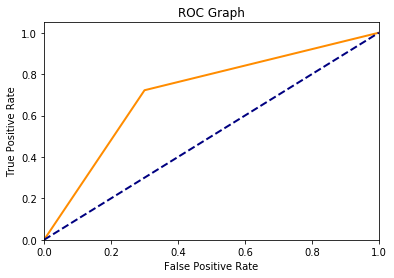

In [32]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

Here we create a range of values to test the model against to determine which parameters provide the best result.

In [33]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [34]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrain, yTrain)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 00:52:09.106832
Wall time: 747 ms
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.678 (+/-0.082) for {'C': 1}
0.632 (+/-0.151) for {'C': 10}
0.632 (+/-0.183) for {'C': 100}
0.592 (+/-0.202) for {'C': 1000}



Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [35]:
cls = SVC(C = bestValues['C'], kernel = 'linear')

In [36]:
# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
print("Accuracy Value:\n {}".format(accuracy_score(yTest,y_hat)))
print("Confusion Matrix:\n {}".format(confusion_matrix(yTest, yhat)))
print("Classification Report:\n {}".format(classification_report(yTest, yhat)))

Accuracy Value:
 0.7340425531914894
Confusion Matrix:
 [[27 13]
 [11 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69        40
           1       0.77      0.80      0.78        54

   micro avg       0.74      0.74      0.74        94
   macro avg       0.74      0.74      0.74        94
weighted avg       0.74      0.74      0.74        94



Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

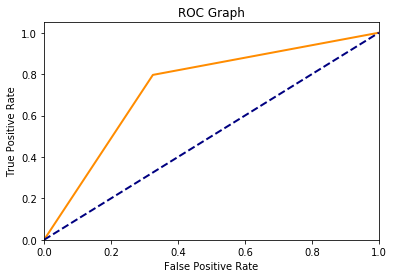

In [37]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

### Most influential Support Vectors
The graph below helps us determine which attributes have the most impact on the boundary between support vectors. This gives us some indication of what attributes might help increase the number of students enrolled in postsecondary education.

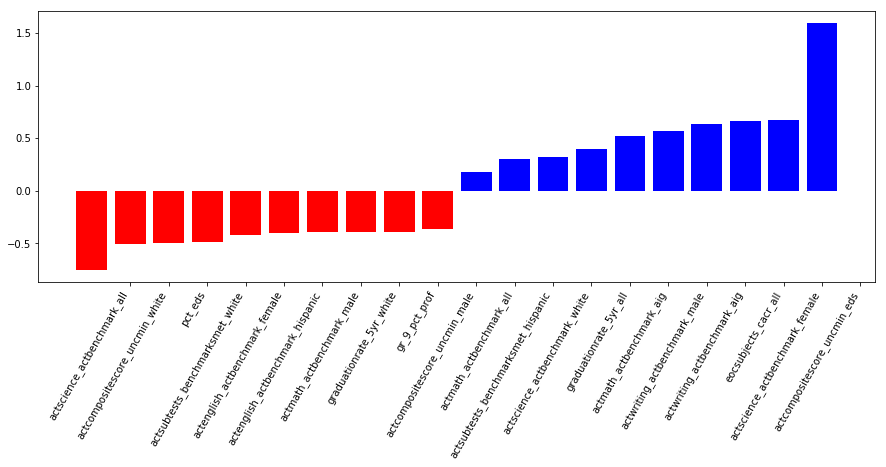

In [38]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

<a href="#top">Back to Top</a>
<a id="Model"></a>
## Model Advantages (10 points)

Logistic regression and support vector machine (SVM) are both classification models and rely on differently constructed algorithms. Selecting an optimal model depends on the question at hand and the dataset with which one is working. In general terms, there are advantages and limitations to both, which should be considered when designing analysis.

#### Logistic Regression

Logistic regression is a model that describes probability (or population proportion) as a function of explanatory variables, where the and interpretations of regression coefficients are made in terms of statements about odds and odds ratios. Advantages of logistic regression are that it tends to be robust to small noise in a dataset and is not affected by mild cases of multi-collinearity (where redundant, strongly correlated variables impact results in a model).

Limitations to be mindful of when working with logistic regression include being aware of overfitting the model, the presence of a large number of features (feature space) or instances of missing data, and datasets containing a large number of categorical variables. These, of course, can be addressed in the data preparation phase of analysis as well as in the parameters of the actual models. For example, weight parameters can be used to help control overfitting. 

#### Support Vector Machine

As Dr. Larson noted in the class videos, SVM is “arguably one of the most exciting topics you will see in machine learning.” It is a classification technique, with “roots in statistical learning theory,” that works to find a decision boundary that divides the data into classes. Advantages of this versatile model are that it works for both linear and non-linear decision boundaries and handle a large feature space. However, since it is more complex than simply creating a line, the algorithm can be much slower to train data than other techniques.  

An important SVM concept is the maximal margin hyperplane, or the maximum margin, which will yield the optimal decision boundary. A boundary with large margins tends to have better generalization errors; a boundary with small margins tend to overfit and perform poorly on test or new data. When defining the SVM algorithm, one needs to decide on the cost parameter. Low cost allows for a wide margin and a higher number of errors, where high costs allows for narrower margins and lower errors. 


#### Model Performance

Working the North Carolina attainment data set, the team built logistic regression and SVM models to predict if approximately 52% or more students at a school enrolled in post-secondary education after graduation. We used the 2017 high school machine learning data set (PublicHighSchool2017_ML from https://github.com/jakemdrew/EducationDataNC).

*Data Perparation*
In order to build the models, the team took several steps to prepare, cull, and scale the data, which included: removing variables with 0 variance (1 column) and removing variables with a Pearson correlation greater than 80% (reduced data by about 30.77% or 124 columns); this helped to temper multi-collinearity and overfitting. Additionally, we encoded our response variable - % of student enrolling in post-secondary education - to a binary field and removed variables about enrollemnt from the data set, as to not use enrollment data in building the models. Finally, we split the data by 80% training and 20% test and scaled the data using the mean and standard deviation of the training data set. 


*Logistic Regression Performance*

| LR SUMMARY | Penalty | Cost | Accuracy | Two Std Dev |
|------------|------------|------|----------|-------------|
| LR Model 1 | L1 - Lasso | 1 | 0.67 | +/- 0.08 |
| LR Model 2 | L1 - Lasso | 0.05 | 0.70 | +/- 0.09 |
| LR Model 3 | L2 - Ridge | 1 | 0.68 | +/- 0.07 |
| LR Model 4 | L2 - Ridge | 0.05 | 0.68 | +/- 0.09 |


Overall, the Logistic Regression models performed similarly as noted above. The model with Lasso Regression and a low-cost value of 0.05 had the highest accuracy but also had the largest variation. The models all ran with similar times, so there is no perceptible difference in terms of training time or efficiency within the Logistic Regression set up. Given the size of our data set, we did not have to use Stochastic Gradient Descent to optimize the Logistic Regression models.

#### SVM Performance

The SVM models were built on two data sets using two different kernels to create the decision boundaries. The two data sets used were named: Correlation, where we reduced the variables using the same methods in the Logistic Regression data based on 80% or greater Pearson value; and ANOVA, where feature selection was employed to determine the top 10% of variables based on the proportion of variance explained by the features (or groups of features).

| SVM Summary | Data Set | Accuracy | Precision | Recall | F1-Score |
|---------------------|-------------|------|-----------|--------|----------|
| Linear Kernel Model | Correlation | 0.73 | 0.62 | 0.61 | 0.61 |
| Linear Kernel Model | ANOVA | 0.74 | 0.74 | 0.74 | 0.74 |
| RBF Kernel Model | ANOVA | 0.71 | 0.72 | 0.71 | 0.71 |

The SVM Linear Kernel Model, using the data set reduced by ANOVA methods, performed the best of the three models. The models all ran with similar times - in under about under a minute - so there is no perceptible difference in terms of training time or efficiency within the SVM set up. As noted above, we did not have to use Stochastic Gradient Descent to optimize the models. 

Definitions:
-	Precision: ratio of true positives / true positives + false positives; ability of the model to not label a sample as positive when it is negative.
-	Recall: The recall is the ratio true positive / true positives + false negatives; ability of the model to find all the positive samples.
-	F1-Score: a weighted harmonic mean of the precision and recall, where an F1-score reaches its best value at 1 and worst score at 0.

#### Comparative Performance

Overall, the SVM models performed slightly better than the Logistic Regression models, but not by a significant margin, and performing better than chance. We were able to get an average accuracy around 70% for both models. Due to the number of instances and attributes, the models were very similar in speed for calculating the coefficient weights. The number of parameters that could be adjusted within SVM allows for more permutations to be tested to find the best model, increasing the time to determine the best parameters.

Citation: 
https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/

Ramsey, F. L., and Schafer, D. W. (2013), The Statistical Sleuth: A
Course in Methods of Data Analysis (3rd ed.), Boston, MA: Brooks/Cole.

Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

<a href="#top">Back to Top</a>
<a id="Interpret"></a>
## Interpret Feature Importance (30 points)

| Attribute | Description | Weight | Odds Ratio |
|------------------------------------|-----------------------------------------------------------------------------------------------------------------|--------|------------|
| pct_eds | % of Economically disadvantaged students | -0.065 | 0.937 |
| TwoOrMoreMalePct | % of male students identifying with 2 or more demographics | -0.051 | 0.949 |
| HispanicMalePct | % of Hispanic Male students | -0.031 | 0.970 |
| grades_1_to_1_access_9:10:11 | Description Unavailable | -0.026 | 0.974 |
| GraduationRate_4yr_LEP | 4-year graduation rate for Limited English Proficiency | -0.012 | 0.987 |
| Math_I_Size | State Math Score | 0.009 | 1.01 |
| ACTCompositeScore_UNCMin_AIG | ACT composite score with University of North Carolina standards for Academically/Intellectually Gifted students | 0.015 | 1.01 |
| ACTSubtests_BenchmarksMet_Hispanic | ACT subtest scores meeting benchmarks for Hispanic students | 0.054 | 1.06 |
| EOCMathI_CACR_AIG | End of Course Math 1 scores for College and Career Ready Academically/Intellectually Gifted students | 0.128 | 1.137 |
| ACTWorkKeys_SilverPlus_AIG | ACT Work Keys scores (10th grade) at Silver or Gold benchmark for Academically/Intellectually Gifted students | 0.169 | 1.185 |
| GraduationRate_5yr_All | 5-year Graduation Rate of all students | 0.193 | 1.213 |
| ACT_Score | Score on ACT | 0.478 | 1.613 |


The explanatory variables that were found to be significant and have a negative impact on the percent of students who enroll in college in decreasing absolute value of odds ratio are:

*pct_eds, 0.93705924*<br>
An increase in percent of economically disadvantaged students decreases the odds of those students at that school from enrolling in college post high school. This can be explained in multiple ways. Students’ families who have less income cannot afford luxuries that other students might have. Examples could be an internet connection, tutors, books, a computer, etc. As we’ll see the most important aspect to increase ones odds at enrolling in college is an ACT score, so these students likely cannot afford to take classes that would help boost their score.

*TwoOrMoreMalePct, 0.949613627* <br>
As the percent of male students who identify as two or more demographics increases at a school, the lower the percent of the student body who enrolls in college. This can be interpreted as the increase in minority (more specifically biracial here) children the less likely the students will enroll in college.

*HispanicMalePct, 0.969924269* <br>
Similarly to the increase in biracial male students, the increase in percent of Hispanic male students at a school will decrease the schools percent in students who enroll in college.

*GraduationRate_4yr_LEP, 0.987716081* <br>
The weakest of the negative weights is the four year graduation rate for limited English proficiency students. Graduation rates of any kind would of course be negatively correlated the percentage of students who enroll in college. This also ties in with the previous negative weight of Hispanic male percentage in the student body population.<br><br>
It is a clear consistent theme from our model that the schools with student bodies who have a higher percentage of Hispanics and biracial males, students who have limited English proficiency, and are economically disadvantaged are the biggest detriments to a schools percentage of students who enroll in college. This of course is not to say that their ethnicity is the cause of the lack of college enrollment at a school. But correlations can likely be found between the negative weighted attributes of poverty and high minorities at a high school.

The explanatory variables that were found to be significant and have a positive impact on the percent of students who enroll in college in increasing absolute value of odds ratio are:

*Math_I_Size, 1.009298017*<br>
This refers to just the general state math score. An increase in a student’s math score would correspond to a higher likelihood of them enrolling in college. Along with ACT scores, these are the only repeating attributes that positively effect a student’s odds of enrolling in college post graduating when increased.

*ACTCompositeScore_UNCMin_AIG, 1.015139594*<br>
For ACT composite scores that met and exceeded the standards set by the University of North Carolina for academically/intellectually gifted student, their odds in enrolling in college would increase. This makes sense due to if you were able to acquire an ACT score so high that you would meet the high criteria set for UNC that you would be able to enroll there or elsewhere.

*ACTSubtests_BenchmarksMet_Hispanic, 1.055001217*<br>
For ACT scores that met and exceeded the benchmark for Hispanic students the likelihood of a student enrolling in college after graduation would increase.

*EOCMathI_CACR_AIG, 1.136777066*<br>
For the students that were academically/intellectually gifted the increase in their end of course math 1 scores would increase the likelihood of them enrolling in college post-graduation.

*ACTWorkKeys_SilverPlus_AIG, 1.184900637*<br>
For the students that were academically/intellectually gifted the increase in their Work Key score will increase their odds of enrolling in college.

*GraduationRate_5yr_All, 1.21301939*<br>
Tracking the graduation rate from 9-12 over a four year and five year period. This metric measures the graduation rate of students at schools over a five year span. This would coincide with an increase in the percent of a student enrolling in college because an increase in this metric would mean more students graduated high school. Therefore, if you at least graduated from high school on time the odds of you enrolling in college are much more likely than if you did not graduate.

*ACT_Score, 1.613285839*<br>
The positive impact of a higher ACT score for the increased odds of a student enrolling in college after high school is obvious for that the test is used to help rank applicants in their college enrollment process. It’s also of note that students in North Carolina are required to take the ACT in 11th grade (junior year) so the test should be uniformly taken across all schools/districts across the state.<br>

By far and away the highest impact an attribute can have on increasing the percentage of students who enroll in college 18 months after graduating from high school is their ACT score. Its odds ratio (1.613) is 133% of the next highest odds ratio (5 year graduation rate, 1.213). Since the ACT and SAT are staples of the college enrollment process this would make sense that such a direct attribute in the application process would weigh so heavily on a student enrolling in our model. Three other attributes in our model are subsets of attributes of the ACT score, that’s how heavily this is weighed. If our data was pared down even more to only include the attribute ACT score, it would very likely increase the weight and odds ratio of this attribute even more. This has no doubt been studied before and would lend credence to the widespread business of SAT and ACT classes that sell the promise of increased scores so their students have an increased likelihood of enrolling in college at all, or to more prestigious ones.

<a href="#top">Back to Top</a>
<a id="Support"></a>
## Interpret Support Vectors (10 points)

The best performing SVM model was the third model which used a linear kernel and the ANOVA feature selection attributes to predict if a school would have 52% postsecondary enrollment. An RBF non-linear kernel was examined but did not perform better than the linear model. The weights represent the hyperplane for that attribute where it thinks the best boundary for classification belongs. By taking the dot product of an instance with that vector, one can determine which side of the decision boundary it lies. The higher the value of the coefficient suggests a higher level of importance on being able to classify an instance. [1] The main support vectors all center around the performance of the students on the ACT. The ACT attributes were strong indicators of the resulting classification result. The ACTCompositeScore_UNCMin_Female variable has the highest weight out of all of the variables in our SVM model. The second highest weight is Gr_9_Pct_Prof. These two variables have the most influence on our model being able to correctly classify the instance. This is to be expected since NC public schools require all first time grade 11 students to take the test. [2] In addition, many colleges use these scores to select which students are admitted to the University so it strongly influences whether a student is accepted into college or not. The different demographics associated with the individual columns suggest there is some correlation between how the demographics of a school impact its postsecondary enrollment rate. This would require further analysis to determine the impact of the demographics on the model.

Citations: 
[1] https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights
[2] http://www.ncpublicschools.org/docs/accountability/policyoperations/2017/1718-actfaq.pdf)